# Proje: MS Hastaları İçin Engellilik Skoru (EDSS) Tahmini

**Amaç:** Bu proje, hastalara ait demografik veriler ile beyin MR'larından elde edilen sayısal ölçümleri (toplam lezyon hacmi, lezyon sayısı vb.) kullanarak, hastanın engellilik skorunu (EDSS) tahmin eden bir makine öğrenmesi modeli geliştirmeyi hedefler.

**Yaklaşım:** Bu bir **regresyon** problemidir. Girdi olarak bir tablo verisi alıp, çıktı olarak sürekli bir sayısal değer (EDSS skoru) üreten klasik makine öğrenmesi modelleri (örneğin, Random Forest) kullanacağız. Bu notebook, görüntü işleme (CNN) **içermez**.

In [1]:
!pip install xgboost

In [2]:
# Gerekli Kütüphanelerin Yüklenmesi
import os
import pandas as pd
import nibabel as nib
import numpy as np
from tqdm import tqdm
from pathlib import Path
import joblib
from scipy.ndimage import label
import xgboost as xgb

# Makine Öğrenmesi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


## Adım 1: Veri Yükleme ve Özellik Mühendisliği (Feature Engineering)

Bu adımda, farklı kaynaklardan (klinik excel dosyası, lezyon maskeleri) gelen verileri birleştirerek modelimizi eğitmek için kullanacağımız ana veri çerçevesini (DataFrame) oluşturacağız.

In [3]:
MRI_BASE_PATH = Path("../BrainCancerClassification/BrainCancerClassification/Data/MultipleSclerosisMRI")

print("Klinik veriler yükleniyor...")
clinical_df = pd.read_excel(MRI_BASE_PATH / "InfoPatient.xlsx", header=1)
clinical_df.rename(columns={"ID": "PatientID"}, inplace=True)

required_cols = ['PatientID', 'Age', 'Gender', 'EDSS', 'Age of onset']
clinical_df = clinical_df[required_cols].copy()
clinical_df.dropna(subset=['EDSS'], inplace=True)
clinical_df['Disease Duration (Years)'] = clinical_df['Age'] - clinical_df['Age of onset']
print("Klinik veri işlendi ve 'Disease Duration (Years)' sütunu eklendi.")


patient_folders = sorted([f for f in os.listdir(MRI_BASE_PATH) if f.startswith("Patient")])
flair_lesion_features = []

for folder in tqdm(patient_folders, desc="FLAIR Lezyon Hacimleri ve Sayıları Hesaplanıyor"):
    pid = int(folder.split("-")[-1])
    try:
        seg_path = MRI_BASE_PATH / folder / f"{pid}-LesionSeg-Flair.nii"
        seg_data = nib.load(seg_path).get_fdata()
        
        flair_lesion_features.append({
            'PatientID': pid,
            'LesionVoxelCount_FLAIR': np.count_nonzero(seg_data),
            'LesionCount_FLAIR': label(seg_data)[1]
        })
    except FileNotFoundError:
        continue
flair_lesion_df = pd.DataFrame(flair_lesion_features)


t1_lesion_features = []
for folder in tqdm(patient_folders, desc="T1 Black Hole Hacimleri ve Sayıları Hesaplanıyor"):
    pid = int(folder.split("-")[-1])
    try:
        seg_path = MRI_BASE_PATH / folder / f"{pid}-LesionSeg-T1.nii"
        seg_data = nib.load(seg_path).get_fdata()
        
        t1_lesion_features.append({
            'PatientID': pid,
            'BlackHole_VoxelCount_T1': np.count_nonzero(seg_data),
            'BlackHole_Count_T1': label(seg_data)[1]
        })
    except FileNotFoundError:
        continue
t1_lesion_df = pd.DataFrame(t1_lesion_features)

print(f"Klinik veri: {len(clinical_df)} hasta")
print(f"FLAIR lezyon verisi: {len(flair_lesion_df)} hasta")
print(f"T1 lezyon verisi: {len(t1_lesion_df)} hasta")

print("\nTüm veri kaynakları birleştiriliyor...")
final_df = pd.merge(clinical_df, flair_lesion_df, on="PatientID", how="inner")
final_df = pd.merge(final_df, t1_lesion_df, on="PatientID", how="inner")
print(f"TÜM VERİLER BİRLEŞTİRİLDİKTEN SONRA (final_df): {len(final_df)} hasta")

print(f"Toplam {len(final_df)} hasta için birleştirilmiş ve zenginleştirilmiş veri seti oluşturuldu.")
print("\nOluşturulan veri setinin ilk 5 satırı:")
display(final_df.head())
print("\nVeri setinin özeti:")
final_df.info()

Klinik veriler yükleniyor...
Klinik veri işlendi ve 'Disease Duration (Years)' sütunu eklendi.


T1 Black Hole Hacimleri ve Sayıları Hesaplanıyor: 100%|██████████| 60/60 [00:12<00:00,  5.00it/s]

Klinik veri: 60 hasta
FLAIR lezyon verisi: 60 hasta
T1 lezyon verisi: 60 hasta

Tüm veri kaynakları birleştiriliyor...
TÜM VERİLER BİRLEŞTİRİLDİKTEN SONRA (final_df): 60 hasta
Toplam 60 hasta için birleştirilmiş ve zenginleştirilmiş veri seti oluşturuldu.

Oluşturulan veri setinin ilk 5 satırı:


,PatientID,Age,Gender,EDSS,Age of onset,Disease Duration (Years),LesionVoxelCount_FLAIR,LesionCount_FLAIR,BlackHole_VoxelCount_T1,BlackHole_Count_T1
0,1,56,F,3.0,43,13,776,52,416,8
1,2,29,F,1.5,19,10,2485,33,3666,12
2,3,15,F,4.0,8,7,2273,65,622,9
3,4,24,F,6.0,20,4,4906,21,4212,34
4,5,33,F,0.0,31,2,2109,59,1053,7



Veri setinin özeti:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PatientID                 60 non-null     int64  
 1   Age                       60 non-null     int64  
 2   Gender                    60 non-null     object 
 3   EDSS                      60 non-null     float64
 4   Age of onset              60 non-null     int64  
 5   Disease Duration (Years)  60 non-null     int64  
 6   LesionVoxelCount_FLAIR    60 non-null     int64  
 7   LesionCount_FLAIR         60 non-null     int64  
 8   BlackHole_VoxelCount_T1   60 non-null     int64  
 9   BlackHole_Count_T1        60 non-null     int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 4.8+ KB


In [4]:
# Veri setinin özetini ve tiplerini kontrol edelim
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PatientID                 60 non-null     int64  
 1   Age                       60 non-null     int64  
 2   Gender                    60 non-null     object 
 3   EDSS                      60 non-null     float64
 4   Age of onset              60 non-null     int64  
 5   Disease Duration (Years)  60 non-null     int64  
 6   LesionVoxelCount_FLAIR    60 non-null     int64  
 7   LesionCount_FLAIR         60 non-null     int64  
 8   BlackHole_VoxelCount_T1   60 non-null     int64  
 9   BlackHole_Count_T1        60 non-null     int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 4.8+ KB


## Adım 2: Model İçin Veriyi Hazırlama

Oluşturduğumuz tablodan modelin öğreneceği özellikleri (X) ve tahmin edeceği hedefi (y) seçecek, ardından bu veriyi eğitim ve test setleri olarak ikiye ayıracağız.

In [5]:
# Kategorik olan 'Gender' sütununu sayısal hale getirelim (One-Hot Encoding)
if 'Gender' in final_df.columns:
    final_df = pd.get_dummies(final_df, columns=['Gender'], drop_first=True)
    gender_col_name = 'Gender_M'
else:
    gender_col_name = None

features = [
    'Age', 
    'Disease Duration (Years)', 
    'LesionVoxelCount_FLAIR', 
    'LesionCount_FLAIR',
    'BlackHole_VoxelCount_T1',
    'BlackHole_Count_T1'
]
if gender_col_name:
    features.append(gender_col_name)

target = 'EDSS'

print(f"\nModel için kullanılacak özellikler: {features}")

final_df.dropna(subset=features + [target], inplace=True)

X = final_df[features]
y = final_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nEğitim seti boyutu: {X_train.shape[0]} hasta")
print(f"Test seti boyutu: {X_test.shape[0]} hasta")


Model için kullanılacak özellikler: ['Age', 'Disease Duration (Years)', 'LesionVoxelCount_FLAIR', 'LesionCount_FLAIR', 'BlackHole_VoxelCount_T1', 'BlackHole_Count_T1', 'Gender_M']

Eğitim seti boyutu: 48 hasta
Test seti boyutu: 12 hasta


## Adım 3: Modelin Oluşturulması ve Eğitilmesi

Bu problem için robust ve yorumlanabilir olması nedeniyle **Random Forest Regressor** modelini kullanacağız. Model, verdiğimiz özellikler ve EDSS skorları arasındaki ilişkiyi öğrenecektir.

In [6]:
param_grid = {
    'max_depth': [3, 5, 7],             
    'n_estimators': [100, 200, 300],    
    'learning_rate': [0.01, 0.05, 0.1], 
    'subsample': [0.7, 0.8, 1.0],       
    'colsample_bytree': [0.7, 0.8, 1.0] 
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# GridSearchCV nesnesi
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    verbose=2 
)

print("GridSearchCV ile en iyi XGBoost parametreleri aranıyor...")
grid_search.fit(X_train, y_train)

print("\nArama tamamlandı.")
print(f"En iyi parametreler: {grid_search.best_params_}")
print(f"Bu parametrelerle elde edilen en iyi skor (Negatif Ortalama Mutlak Hata): {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_

print("\n--- En İyi Model ile Test Seti Üzerinde Final Değerlendirme ---")

predictions = best_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Ortalama Mutlak Hata (MAE): {mae:.3f}")
print(f"R-kare (R²) Skoru: {r2:.3f}")
print(f"\nOptimize edilmiş model, test setindeki EDSS skorlarını ortalama +/- {mae:.2f} puan farkla tahmin etmektedir.")

GridSearchCV ile en iyi XGBoost parametreleri aranıyor...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_

## Adım 4: Model Değerlendirme

Modelimizin ne kadar başarılı olduğunu görmek için test seti üzerinde tahminler yapacak ve performansını ölçeceğiz.

* **Ortalama Mutlak Hata (MAE):** Modelimizin tahminlerinin gerçek değerlerden ortalama ne kadar saptığını gösterir. Düşük olması daha iyidir.
* **R-kare (R²):** Modelimizin, hedef değişkendeki varyansın ne kadarını açıklayabildiğini gösterir. 1'e ne kadar yakınsa o kadar iyidir.

In [7]:
# Test seti üzerinde tahmin yap
predictions = best_model.predict(X_test)

# Performans metriklerini hesapla
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Ortalama Mutlak Hata (MAE): {mae:.3f}")
print(f"R-kare (R²) Skoru: {r2:.3f}")
print(f"\nModelimiz, test setindeki EDSS skorlarını ortalama +/- {mae:.2f} puan farkla tahmin etmektedir.")

Ortalama Mutlak Hata (MAE): 1.441
R-kare (R²) Skoru: -0.276

Modelimiz, test setindeki EDSS skorlarını ortalama +/- 1.44 puan farkla tahmin etmektedir.


### Grafik Değerlendirme


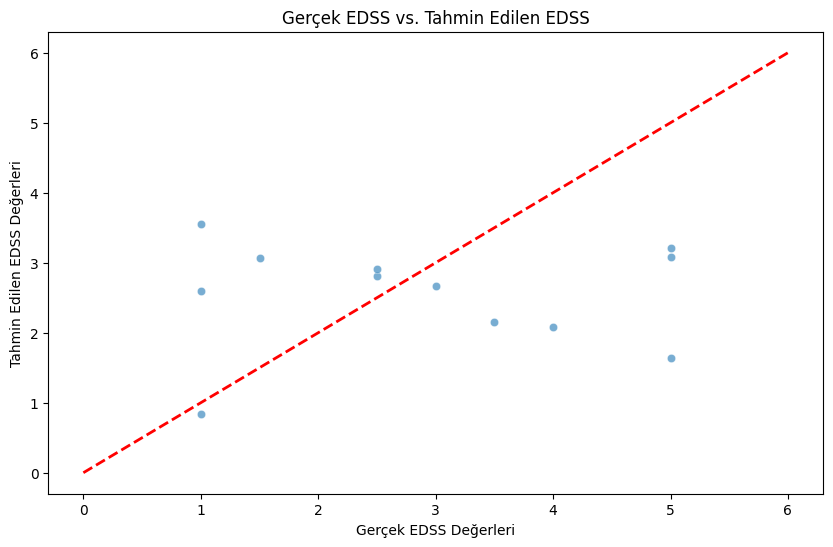

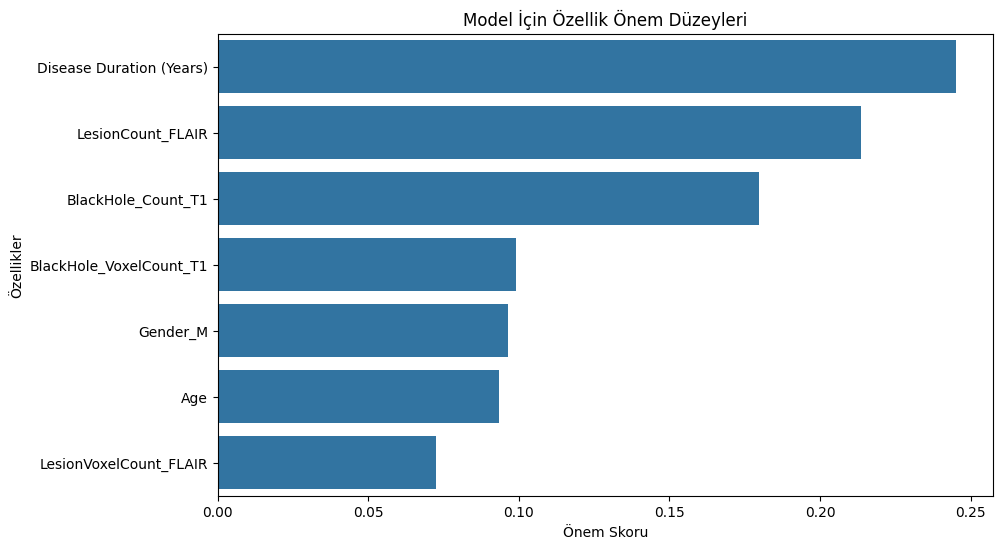

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', linewidth=2) 
plt.title('Gerçek EDSS vs. Tahmin Edilen EDSS')
plt.xlabel('Gerçek EDSS Değerleri')
plt.ylabel('Tahmin Edilen EDSS Değerleri')
plt.show()

feature_importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Model İçin Özellik Önem Düzeyleri')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellikler')
plt.show()

## Adım 5: Modelin Kaydedilmesi


In [9]:
# Modeli kaydet
model_filename = "edss_prediction_xgboost.joblib"
joblib.dump(best_model, model_filename)

print(f"Model başarıyla '{model_filename}' olarak kaydedildi.")

Model başarıyla 'edss_prediction_xgboost.joblib' olarak kaydedildi.
